In [30]:
paper_data_file = "data/paper_data.csv"
citations_file = "data/citations.csv"

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from time import time


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [32]:
paper_data = pd.read_csv(paper_data_file)
print(paper_data.columns)
citations = pd.read_csv(citations_file)
print(citations.columns)

Index(['paperId', 'title', 'embedding'], dtype='object')
Index(['source', 'target'], dtype='object')


In [33]:
def get_embedding_matrix(series):
    return np.vstack(series.apply(eval).apply(np.array).values)

all_embeddings = get_embedding_matrix(paper_data.embedding)
all_embeddings = StandardScaler().fit_transform(all_embeddings)
print(all_embeddings.shape)

embeddings_pca_10 = PCA(n_components=10).fit_transform(all_embeddings)
print(embeddings_pca_10.shape)
embeddings_pca_50 = PCA(n_components=50).fit_transform(all_embeddings)
print(embeddings_pca_50.shape)

(3083, 768)

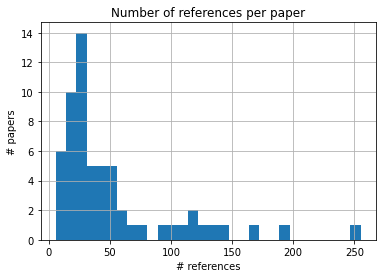

In [41]:
citations.groupby("source").count().hist(bins=30)
plt.title("Number of references per paper")
plt.xlabel("# references")
plt.ylabel("# papers")
plt.show()

In [80]:
def select_data(embeddings, source_paper, n_positive, n_negative, n_counterexamples=100):
    """Given a source paper, selects the positive and negative training examples and returns positive and negative test sets.
    """
    not_source_papers = np.setdiff1d(np.unique(citations.source), [source_paper])

    reference_group_ids = citations[citations.source == source_paper].target.values
    reference_group_embeddings = embeddings[paper_data.paperId.isin(reference_group_ids)]
    counterexample_group_ids = citations[citations.source.isin(not_source_papers)].target.values
    counterexample_group_embeddings = embeddings[paper_data.paperId.isin(counterexample_group_ids)]

    references_train_idx = np.random.choice(reference_group_embeddings.shape[0], n_positive, replace=False)
    references_train = reference_group_embeddings[references_train_idx, :]
    references_test = reference_group_embeddings[~references_train_idx, :]

    counterexample_train_idx = np.random.choice(counterexample_group_embeddings.shape[0], n_negative, replace=False)
    counterexample_train = counterexample_group_embeddings[counterexample_train_idx, :]
    counterexample_test_idx = np.random.choice(counterexample_group_embeddings.shape[0], n_counterexamples, replace=False)
    counterexample_test = counterexample_group_embeddings[counterexample_test_idx, :]

    return references_train, references_test, counterexample_train, counterexample_test

In [56]:
def make_name(model):
    if isinstance(model, Pipeline):
        return "+".join(make_name(step) for step in model.named_steps.values())
    else:
        return str(model)

In [86]:
def score_supervised(models, embeddings, n_positive, n_negative):

    precision = np.zeros([len(np.unique(citations.source)), len(models)])
    recall = np.zeros_like(precision)
    train_accuracy = np.zeros_like(precision)
    test_accuracy = np.zeros_like(precision)

    training_time = np.zeros_like(precision)
    inference_time = np.zeros_like(precision)

    n_reference_groups = 0

    for i, source_paper in enumerate(np.unique(citations.source)):
        try:
            good_train, good_test, bad_train, bad_test = select_data(embeddings, source_paper, n_positive, n_negative)
            n_reference_groups += 1
        except ValueError:
            continue
        
        # assemble dataset
        y_train = np.array([1] * len(good_train) + [0] * len(bad_train))
        X_train = np.vstack([good_train, bad_train])
        y_test = np.array([1] * len(good_test) + [0] * len(bad_test))
        X_test = np.vstack([good_test, bad_test])

        for j, model in enumerate(models):
            # train model
            start = time()
            model = model.fit(X_train, y_train)
            training_time[i, j] = time() - start

            # inference
            start = time()
            Y_train_pred = model.predict(X_train)
            y_pred = model.predict(X_test)
            inference_time[i, j] = time() - start

            # evaluate model
            precision[i, j] = precision_score(y_test, y_pred)
            recall[i, j] = recall_score(y_test, y_pred)
            train_accuracy[i, j] = accuracy_score(y_train, Y_train_pred)
            test_accuracy[i, j] = accuracy_score(y_test, y_pred)
    
    results = pd.DataFrame()
    results["model"] = [make_name(model) for model in models]
    results["train_accuracy"] = train_accuracy.mean(axis=0)
    results["test_accuracy"] = test_accuracy.mean(axis=0)
    results["precision"] = precision.mean(axis=0)
    results["recall"] = recall.mean(axis=0)
    results["training_time"] = training_time.mean(axis=0)
    results["inference_time"] = inference_time.mean(axis=0)

    report = {
        "models": [make_name(model) for model in models],
        "results": results,
        "n_reference_groups": n_reference_groups,
        "n_positive": n_positive,
        "n_negative": n_negative,
    }

    return report

In [85]:
models = [LogisticRegression(), SVC()]
results = score_supervised(models, embeddings_pca_50, 10, 10)
print(results["n_reference_groups"])
results["results"]

57


,model,train_accuracy,test_accuracy,precision,recall,training_time,inference_time
0,LogisticRegression(),0.950000,0.719394,0.290104,0.823333,0.008371,0.000210
1,SVC(),0.936667,0.808788,0.416412,0.775000,0.000476,0.000908


In [18]:
class RecenteringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.center = None
    
    def fit(self, X, y):
        self.center = X[y].mean(axis=0)
        return self
    
    def transform(self, X):
        return np.abs(X - self.center)

In [23]:
models = [
    LogisticRegression(),
    make_pipeline(RecenteringTransformer(), LogisticRegression()),
    make_pipeline(PCA(n_components=10), LogisticRegression()),
    # make_pipeline(PCA(n_components=50), LogisticRegression()),

    RandomForestClassifier(),
    make_pipeline(PCA(n_components=10), RandomForestClassifier()),
    # make_pipeline(PCA(n_components=50), RandomForestClassifier()),

    SVC(kernel='linear'),
    SVC(kernel='rbf'),
    make_pipeline(PCA(n_components=10), SVC(kernel='linear')),
    make_pipeline(PCA(n_components=10), SVC()),
]

In [24]:
train_scores = []
test_scores = []
for model in models:
    train_score, test_score = score_model(model)
    train_scores.append(train_score)
    test_scores.append(test_score)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

In [25]:
def make_name(model):
    if isinstance(model, Pipeline):
        return "+".join(make_name(step) for step in model.named_steps.values())
    else:
        return str(model)

model_names = [make_name(model) for model in models]
scores = pd.DataFrame()
scores["model"] = model_names
scores["train"] = train_scores
scores["test"] = test_scores
scores

,model,train,test
0,LogisticRegression(),1.000000,0.970518
1,RecenteringTransformer()+LogisticRegression(),1.000000,0.977910
2,PCA(n_components=10)+LogisticRegression(),0.948454,0.972993
3,RandomForestClassifier(),1.000000,0.985272
4,PCA(n_components=10)+RandomForestClassifier(),1.000000,0.981047
5,SVC(kernel='linear'),1.000000,0.965167
6,SVC(),0.977583,0.984730
7,PCA(n_components=10)+SVC(kernel='linear'),0.951007,0.975696
8,PCA(n_components=10)+SVC(),0.954484,0.982484


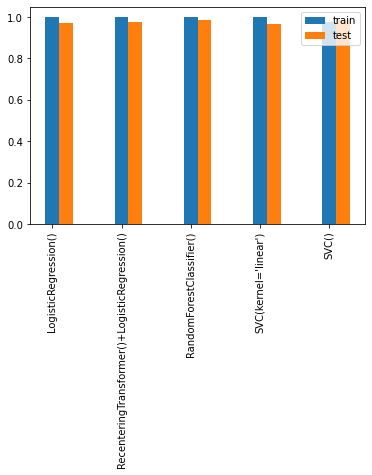

In [22]:
x_pos = np.arange(len(train_scores))
plt.bar(x_pos, train_scores, width=0.2, label="train")
plt.bar(x_pos + 0.2, test_scores, width=0.2, label="test")
plt.xticks(x_pos, model_names, rotation=90)
plt.legend()